In [2]:
import pandas as pd

mat = pd.read_csv("/content/student-mat.csv", sep=";")
por = pd.read_csv("/content/student-por.csv", sep=";")

print("Math dataset shape:", mat.shape)
print("Portuguese dataset shape:", por.shape)


Math dataset shape: (395, 33)
Portuguese dataset shape: (649, 33)


In [3]:
mat.head()
por.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
mat["course"] = "math"
por["course"] = "portuguese"


In [5]:
df = pd.concat([mat, por], axis=0).reset_index(drop=True)

print("Combined dataset shape:", df.shape)


Combined dataset shape: (1044, 34)


In [6]:
df["marks_trend"] = df["G3"] - df["G1"]


In [7]:
df["attendance_pct"] = 100 - (df["absences"] / df["absences"].max()) * 100


In [8]:
def assign_burnout(row):
    if row["absences"] > 15 and row["marks_trend"] < -2 and row["health"] <= 2:
        return 2   # High Risk
    elif row["absences"] > 8 or row["marks_trend"] < 0:
        return 1   # Medium Risk
    else:
        return 0   # Low Risk

df["burnout_risk"] = df.apply(assign_burnout, axis=1)


In [9]:
df["burnout_risk"].value_counts()


,count
burnout_risk,
0,669
1,375


In [10]:
features = [
    "attendance_pct",
    "studytime",
    "failures",
    "health",
    "goout",
    "marks_trend"
]

X = df[features]
y = df["burnout_risk"]


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [13]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       134
           1       1.00      1.00      1.00        75

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209



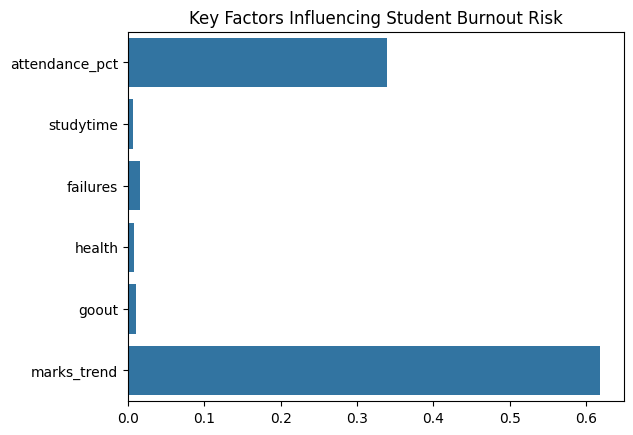

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
sns.barplot(x=importances, y=features)
plt.title("Key Factors Influencing Student Burnout Risk")
plt.show()


In [15]:
import joblib

joblib.dump(rf, "burnout_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved!")


Model and scaler saved!


In [16]:
!ls



burnout_model.pkl  sample_data	scaler.pkl  student-mat.csv  student-por.csv


In [17]:
%%writefile app.py
import streamlit as st
import numpy as np
import joblib
import matplotlib.pyplot as plt

# Load model & scaler
model = joblib.load("burnout_model.pkl")
scaler = joblib.load("scaler.pkl")

st.set_page_config(page_title="Student Burnout Predictor")

st.title("🎓 Student Burnout Risk Predictor")
st.write("ML-based burnout risk prediction using academic & behavioral data")

st.divider()

attendance = st.slider("Attendance Percentage", 40.0, 100.0, 75.0)
studytime = st.slider("Weekly Study Time (1–4)", 1, 4, 2)
failures = st.slider("Number of Past Failures", 0, 4, 0)
health = st.slider("Health Status (1–5)", 1, 5, 3)
goout = st.slider("Social Activity (1–5)", 1, 5, 3)
marks_trend = st.slider("Marks Trend (G3 − G1)", -10.0, 10.0, 0.0)

input_data = np.array([[attendance, studytime, failures, health, goout, marks_trend]])
input_scaled = scaler.transform(input_data)

if st.button("Predict Burnout Risk"):
    prediction = model.predict(input_scaled)[0]

    labels = {
        0: "Low Risk 🟢",
        1: "Medium Risk 🟡",
        2: "High Risk 🔴"
    }

    st.subheader(f"Prediction: {labels[prediction]}")

    st.divider()
    st.subheader("📊 Feature Importance")

    feature_names = [
        "Attendance %",
        "Study Time",
        "Failures",
        "Health",
        "Social Activity",
        "Marks Trend"
    ]

    importances = model.feature_importances_

    fig, ax = plt.subplots()
    ax.barh(feature_names, importances)
    st.pyplot(fig)


Writing app.py


In [18]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 148.8 MB/s eta 0:00:00


In [19]:
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
added 22 packages in 4s
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501


⠙

⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://sixty-bees-rhyme.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.164.160:8501



In [24]:
!curl https://loca.lt/mytunnelpassword


34.125.164.160